In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch
import torch.nn as nn

categories = ['Airplane', 'Alarm', 'Beep/Bleep', 'Bell', 'Bicycle', 'Bird Chirp', 'Bus', 'Car', 'Cat Meow',
        'Chainsaw', 'Clapping', 'Cough', 'Cow Moo', 'Cowbell', 'Crying', 'Dog Bark', 'Doorbell', 'Drip',
        'Drums', 'Fire', 'Footsteps', 'Guitar', 'Hammer', 'Helicopter', 'Hiccup', 'Horn Honk', 'Horse Neigh',
        'Insect Buzz', 'Jackhammer', 'Laughter', 'Lawn Mower', 'Motorcycle', 'Piano', 'Pig Oink', 'Power Drill',
        'Power Saw', 'Rain', 'Rooster Crow', 'Saxophone', 'Sewing Machine', 'Sheep/Goat Bleat', 'Ship/Boat',
        'Shout', 'Singing', 'Siren', 'Sneeze', 'Snoring', 'Speech', 'Stream/River', 'Thunder', 'Train', 'Truck',
        'Trumpet', 'Vacuum Cleaner', 'Violin', 'Washing Machine', 'Waves', 'Wind']

features_dir = "audio_features"
labels_dir = "labels"

animals = ['Bird Chirp', 'Dog Bark', 'Insect Buzz', 'Sheep/Goat Bleat','Cat Meow', 'Cow Moo'
               ,'Horse Neigh', 'Pig Oink', 'Rooster Crow' ]

In [2]:
ann_df = pd.read_csv(
    'annotations.csv'
)
meta_df = pd.read_csv(
    'metadata.csv'
)
ann_df.shape

(27552, 9)

In [3]:
train_filename = meta_df.sample(len(meta_df),random_state=42)['filename'].unique()[:int(len(meta_df)*0.7)]
validation_filename = meta_df.sample(len(meta_df),random_state=42)['filename'].unique()[int(len(meta_df)*0.7):int(len(meta_df)*0.9)]
test_filename = meta_df.sample(len(meta_df),random_state=42)['filename'].unique()[int(len(meta_df)*0.9):len(meta_df)]




In [4]:
def aggregate_labels(file_labels):
    __y = []
    for frame_labels in file_labels:
        if(sum(frame_labels) == 0):
            __y.append([0])
        elif(np.count_nonzero(frame_labels) == len(frame_labels)):
             __y.append([1])
        else: #The annotators don't agree on the label
            __y.append([np.random.choice(frame_labels)])
    return __y

In [5]:
features_dir = "audio_features"
labels_dir = "labels"

import itertools
def read_files(file_names):
    X_train = []
    Y_train = {c: [] for c in categories}  # Initialize label dictionary
    
    for f in file_names:
        # Load melspectrogram and MFCC features
        features_mel = np.load(os.path.join(features_dir, f.split('.')[0] + '.npz'))["melspectrogram"]
        
        
        # Pad or truncate all features to have the same number of timesteps
      
        
        # Concatenate features along feature axis (axis=1)
        #features = np.concatenate([features_mel, features_mfcc], axis=1)
        X_train.append(features_mel)
        
        # Load and process labels
        y = np.load(os.path.join(labels_dir, f.split('.')[0] + '_labels.npz'))
        for c in categories:
            _y = aggregate_labels(y[c])
            Y_train[c].extend(list(itertools.chain.from_iterable(_y)))  # Match length
    
    X_train = np.concatenate(X_train)
    return X_train, Y_train

In [6]:
from sklearn.preprocessing import StandardScaler
def preprocessing(array):
    s=StandardScaler()
    scaled_array = s.fit_transform(array)
    scalar =s.fit(array)
    return scaled_array,scalar.mean_,scalar.scale_

In [7]:
train_x,train_y = read_files(train_filename)
val_x, val_y = read_files(validation_filename)
test_x, test_y = read_files(test_filename)

In [8]:
scaled_train_x,mu,std =preprocessing(train_x)
scaled_validation_x = (val_x - mu)/std
scaled_test_x = (test_x - mu)/std

In [45]:
test_x.shape

(155057, 64)

In [10]:
train_y = np.array([train_y[cls] for cls in categories]).T
val_y = np.array([val_y[cls] for cls in categories]).T
test_y = np.array([test_y[cls] for cls in categories]).T
train_y.shape

(1078243, 58)

In [46]:
device = 'cuda'
def train_model(model):
    import torch
    import torch.nn as nn
    from torch.utils.data import DataLoader, TensorDataset
    from torch.nn.functional import sigmoid

    device = "cuda"
    model.to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([5.0] * 58, device=device))
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    training_loss = []
    validation_loss = []

    # Datasets
    batch_size = 32
    scaled_train_x_tensor = torch.tensor(scaled_train_x, dtype=torch.float32)
    train_y_tensor = torch.tensor(train_y, dtype=torch.float32)
    scaled_validation_x_tensor = torch.tensor(scaled_validation_x, dtype=torch.float32)
    val_y_tensor = torch.tensor(val_y, dtype=torch.float32)

    train_dataset = TensorDataset(scaled_train_x_tensor, train_y_tensor)
    val_dataset = TensorDataset(scaled_validation_x_tensor, val_y_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    num_epochs = 11

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            preds = (sigmoid(output) > 0.5).int()
            targets = y_batch.int()
            train_correct += (preds == targets).sum().item()
            train_total += targets.numel()

        train_accuracy = train_correct / train_total
        avg_train_loss = train_loss / len(train_loader)
        training_loss.append(avg_train_loss)

        # ----------- Validation and Metrics -----------
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)

                val_output = model(x_val)
                val_loss += criterion(val_output, y_val).item()

                probs = sigmoid(val_output)
                preds = (probs > 0.5).int()
                targets = y_val.int()

                all_preds.append(preds)
                all_targets.append(targets)

        avg_val_loss = val_loss / len(val_loader)
        validation_loss.append(avg_val_loss)

        # Stack predictions
        all_preds = torch.cat(all_preds, dim=0)
        all_targets = torch.cat(all_targets, dim=0)

        # Compute metrics
        TP = (all_preds & all_targets).sum(dim=0).float()
        FP = ((all_preds == 1) & (all_targets == 0)).sum(dim=0).float()
        FN = ((all_preds == 0) & (all_targets == 1)).sum(dim=0).float()
        TN = ((all_preds == 0) & (all_targets == 0)).sum(dim=0).float()

        precision = TP / (TP + FP + 1e-8)
        recall = TP / (TP + FN + 1e-8)
        f1 = (2 * precision * recall) / (precision + recall + 1e-8)
        tnr = TN / (TN + FP + 1e-8)
        balanced_acc = (recall + tnr) / 2

        avg_precision = precision.mean().item()
        avg_recall = recall.mean().item()
        avg_f1 = f1.mean().item()
        avg_bal_acc = balanced_acc.mean().item()
        val_accuracy = (all_preds == all_targets).float().mean().item()

        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Train Loss:                  {avg_train_loss:.4f}")
        print(f"Train Accuracy:              {train_accuracy:.4f}")
        print(f"Val Loss:                    {avg_val_loss:.4f}")
        print(f"Validation Accuracy:         {val_accuracy:.4f}")
        print(f"Precision:                   {avg_precision:.4f}")
        print(f"Recall:                      {avg_recall:.4f}")
        print(f"F1 Score:                    {avg_f1:.4f}")
        print(f"Average Balanced Accuracy:   {avg_bal_acc:.4f}")

    # Save model
    torch.save(model.state_dict(), 'CLSTM_WEIGHTS.pth')
    torch.save(model, 'CLSTM.pth')

    return training_loss, validation_loss, {
        "precision": avg_precision,
        "recall": avg_recall,
        "f1": avg_f1,
        "balanced_accuracy": avg_bal_acc,
        "val_accuracy": val_accuracy
    }

In [47]:
def test_model(model):
    import torch
    import torch.nn as nn
    from torch.utils.data import DataLoader, TensorDataset
    from torch.nn.functional import sigmoid

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()  # Set model to evaluation mode
    
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([10.0] * 58,device=device))

    # Datasets
    batch_size = 32
    scaled_test_x_tensor = torch.tensor(scaled_test_x, dtype=torch.float32).to(device)
    test_y_tensor = torch.tensor(test_y, dtype=torch.float32).to(device)

    test_dataset = TensorDataset(scaled_test_x_tensor, test_y_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    test_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            output = model(x_test)
            test_loss += criterion(output, y_test).item()

            probs = sigmoid(output)
            preds = (probs > 0.5).int()
            all_preds.append(preds)
            all_targets.append(y_test.int())

    # Calculate average test loss
    avg_test_loss = test_loss / len(test_loader)

    # Stack predictions for metric calculations
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Calculate metrics
    TP = (all_preds & all_targets).sum(dim=0).float()
    FP = ((all_preds == 1) & (all_targets == 0)).sum(dim=0).float()
    FN = ((all_preds == 0) & (all_targets == 1)).sum(dim=0).float()
    TN = ((all_preds == 0) & (all_targets == 0)).sum(dim=0).float()

    precision = TP / (TP + FP + 1e-8)
    recall = TP / (TP + FN + 1e-8)
    f1 = (2 * precision * recall) / (precision + recall + 1e-8)
    tnr = TN / (TN + FP + 1e-8)
    balanced_acc = (recall + tnr) / 2

    avg_precision = precision.mean().item()
    avg_recall = recall.mean().item()
    avg_f1 = f1.mean().item()
    avg_bal_acc = balanced_acc.mean().item()
    test_accuracy = (all_preds == all_targets).float().mean().item()

    # Print results
    print("\nTest Results")
    print(f"Test Loss:                 {avg_test_loss:.4f}")
    print(f"Test Accuracy:             {test_accuracy:.4f}")
    print(f"Precision:                 {avg_precision:.4f}")
    print(f"Recall:                    {avg_recall:.4f}")
    print(f"F1 Score:                  {avg_f1:.4f}")
    print(f"Average Balanced Accuracy: {avg_bal_acc:.4f}")

    return {
        "test_loss": avg_test_loss,
        "test_accuracy": test_accuracy,
        "precision": avg_precision,
        "recall": avg_recall,
        "f1": avg_f1,
        "balanced_accuracy": avg_bal_acc
    }


In [48]:
import torch
import torch.nn as nn

class CLSTM(nn.Module):
    def __init__(self, num_classes=58, num_layers=1):
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.Conv1d(64, 62, 3, padding='same'),
            nn.BatchNorm1d(62),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv1d(62, 32, 3, padding='same'),
            nn.BatchNorm1d(32),
            nn.ReLU()
        )
        self.bilstm = nn.LSTM(
            input_size=32,  
            hidden_size=32,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=False
        )
   
        self.classifier = nn.Sequential(
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(0)  
        x = x.permute(0, 2, 1)
        x = self.conv(x)          
        x = x.permute(0, 2, 1)
        x= x.squeeze(0)
        
        lstm_out, _ = self.bilstm(x)
        logits = self.classifier(x)  
        
        return logits

**Report**
* a hybrid model where we used 2 1-dimensional conv layer. why?-> cnns have been established to be good at recognizing patterns and feature extraction , then we used a lstm layer to process thesqeunce of extraxted features from the conv layers and lastly we used a linear layer as he classifying layer.
* we did not use bidirection lstm here since training the lstm model showed us that bilstsm tend to overfit

In [49]:
model = CLSTM().to('cuda')

In [50]:
training_loss,validation_loss,eval_dict =  train_model(model)


Epoch 1/11
Train Loss:                  0.2583
Train Accuracy:              0.9729
Val Loss:                    0.2530
Validation Accuracy:         0.9724
Precision:                   0.1639
Recall:                      0.1110
F1 Score:                    0.1104
Average Balanced Accuracy:   0.5501

Epoch 2/11
Train Loss:                  0.2467
Train Accuracy:              0.9719
Val Loss:                    0.2479
Validation Accuracy:         0.9711
Precision:                   0.1890
Recall:                      0.1228
F1 Score:                    0.1248
Average Balanced Accuracy:   0.5549

Epoch 3/11
Train Loss:                  0.2432
Train Accuracy:              0.9716
Val Loss:                    0.2463
Validation Accuracy:         0.9720
Precision:                   0.2236
Recall:                      0.1264
F1 Score:                    0.1328
Average Balanced Accuracy:   0.5571

Epoch 4/11
Train Loss:                  0.2416
Train Accuracy:              0.9715
Val Loss:       

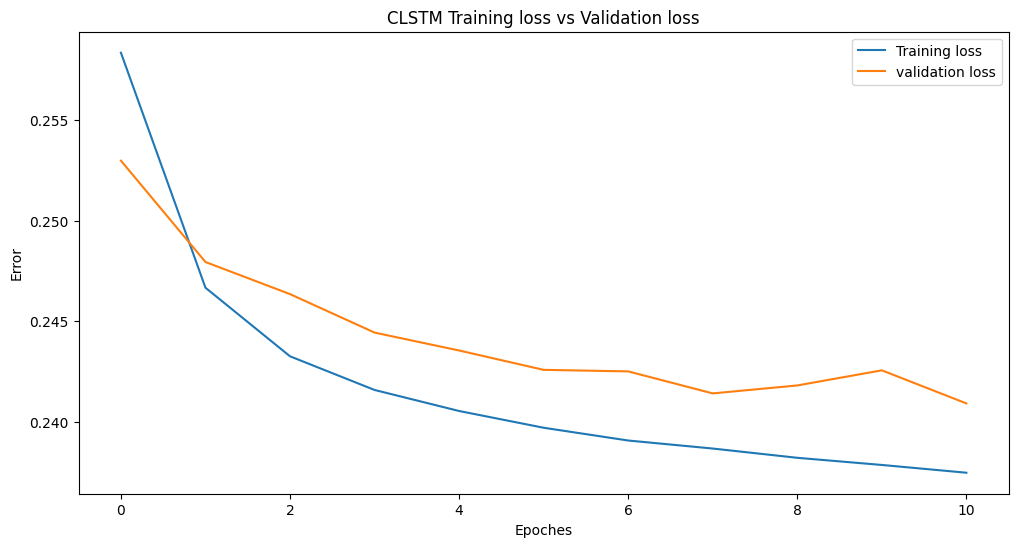

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
fig,ax = plt.subplots(1,1,figsize=(12,6))
ax.plot(range(11),training_loss,label="Training loss")
ax.plot(range(11),validation_loss,label="validation loss")
ax.set_title("CLSTM Training loss vs Validation loss")
ax.set_xlabel("Epoches")
ax.set_ylabel("Error")
plt.legend()

In [53]:
test_model(model)


Test Results
Test Loss:                 0.4125
Test Accuracy:             0.9715
Precision:                 0.2288
Recall:                    0.1435
F1 Score:                  0.1469
Average Balanced Accuracy: 0.5653


{'test_loss': 0.41252439770212584,
 'test_accuracy': 0.9714919924736023,
 'precision': 0.22884000837802887,
 'recall': 0.1435440629720688,
 'f1': 0.1468793898820877,
 'balanced_accuracy': 0.5653191804885864}

In [ ]:
test_model(BiLSTM)

In [54]:
torch.save(model.state_dict(), 'CLSTM_weights.pth')
torch.save(model, 'CLSTM_model.pth')